In [1]:
import os
import torch
import ds.paths as d_path
import torchvision

from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets, check_best, end_train, evaluate, train_one_epoch
from torchvision.models import resnet18, ResNet18_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from ds.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.classification import ClassificationEvaluator, load_cl_pretrained, resnet_set_trainable_layers
from models.classification import MultiBinaryClassificationModel
from torchvision.models.detection import FasterRCNN
import warnings
import pandas as pd
from utils.plot import plot_train
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device() # torch.device("cpu") # 
# device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large 

In [3]:
image_size = 128 # 128
batch_size = 4
epochs = 50
linear_eval = False
model_name = "swav"
representation_size = 32 # 1024 in paper, but too large on my PC.

In [4]:
from torchvision import models
from torchmetrics.functional.classification import accuracy

In [5]:
from torch import nn
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from utils.train import get_dataloader_g
import torch.utils.data as data
import math
import numpy as np
from utils.train import collate_fn

# load the model
backbone = resnet18(weights=None)

train_d = data.DataLoader(
    REFLACXLesionDetectionDataset(
        image_size=image_size,
        split_str="train",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    generator=get_dataloader_g(0),
    drop_last=False,
)

# load weights into this backbone then apply fpn.
cp = torch.load(os.path.join("checkpoints", model_name, "model"), map_location=device)

backbone_cp_dict = param_dict = {
    k.replace("img_enc.", ""): v
    for k, v in cp["model"].items()
    if k.startswith("img_enc.")
}

del backbone_cp_dict['fc.weight']
del backbone_cp_dict['fc.bias']

backbone.load_state_dict(backbone_cp_dict, strict=False)

from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor

backbone = _resnet_fpn_extractor(backbone, 0 if linear_eval == True else 5)

if linear_eval:
    for name, param in backbone.body.named_parameters():
        assert param.requires_grad == False, f"{name} should not be trainable"

# backbone_seq = nn.Sequential(
#     *[
#         backbone.conv1,
#         backbone.bn1,
#         backbone.relu,
#         backbone.maxpool,
#         backbone.layer1,
#         backbone.layer2,
#         backbone.layer3,
#         backbone.layer4,
#     ]
# )

# backbone.out_channels = 256  # for resnet18_fpn # _resnet_fpn_extractor do this for you.

# if linear_eval == True:
# for param in backbone.parameters():
#     param.requires_grad_(False)

# for reducing the size of roi_heads
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor

out_channels = backbone.out_channels
box_roi_pool = MultiScaleRoIAlign(
    featmap_names=["0", "1", "2", "3"], output_size=7, sampling_ratio=2
)
resolution = box_roi_pool.output_size[0]
box_head = TwoMLPHead(out_channels * resolution**2, representation_size)
box_predictor = FastRCNNPredictor(
    representation_size,
    train_d.dataset.num_classes() + 1,
)

model = FasterRCNN(
    backbone,
    # num_classes=train_d.dataset.num_classes() + 1,
    box_roi_pool=box_roi_pool,
    box_head=box_head,
    box_predictor=box_predictor,
)

optimizer = torch.optim.AdamW(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=3e-4,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=math.ceil(len(train_d.dataset) / batch_size)
    * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
    eta_min=1e-8,
)

In [11]:
import torch.nn.functional as F

def train_one_epoch(
    model,
    optimizer,
    dataloader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):
    model.to(device)
    model.train()
    iters = math.ceil(len(dataloader.dataset) / train_d.batch_size)

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    losses = []
    for i, (x, y) in enumerate(dataloader):
        x = list(image.to(device) for image in x)
        y = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in y
        ]
        loss_dict = model(x, y)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()
        if lr_scheduler is not None:
            if isinstance(
                lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
            ):
                lr_scheduler.step(epoch + i / iters)
            else:
                lr_scheduler.step()
        losses.append(loss.item())
    return losses

In [12]:
# param_dict = {}
# for n, p in model.named_parameters():
#     param_dict.update({n: {"#params":p.nelement()}})
# pd.DataFrame(param_dict).transpose().sort_values("#params", ascending=False).head(20)

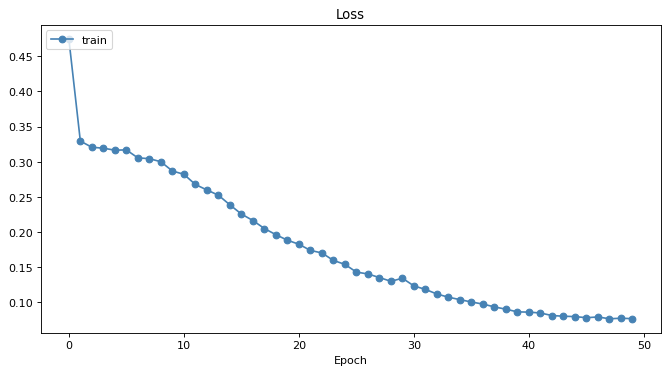

In [13]:
train_losses = []
for epoch in range(epochs):
    train_l = train_one_epoch(
        model,
        optimizer,
        train_d,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    train_losses.append(np.mean(train_l))
    clear_output()
    plot_train(train_losses, title="Loss")

In [14]:
from torchmetrics.detection import MeanAveragePrecision
cpu_device = torch.device("cpu")
@torch.inference_mode()
def evaluate(model, data_loader, device):
    model.to(device)
    model.eval()
    evaluator = MeanAveragePrecision(iou_type="bbox", box_format="xyxy")
    for _, (x, y) in enumerate(data_loader):
        x = list(image.to(device) for image in x)
        y = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in y
        ]
        y_pred = model(x)

        y_pred = [{k: v.to(cpu_device) for k, v in t.items()} for t in y_pred]
        # y = [
        #     {
        #         k: v.to(cpu_device) if isinstance(v, torch.Tensor) else v
        #         for k, v in t.items()
        #     }
        #     for t in y
        # ]
        # out_logits, out_bbox = y_pred["pred_logits"], y_pred["pred_boxes"]
        # prob = F.softmax(out_logits, -1)
        # scores, labels = prob[..., :-1].max(-1)
        # results = [
        #     {"scores": s, "labels": l, "boxes": b}
        #     for s, l, b in zip(scores, labels, out_bbox)
        # ]
        evaluator.update(y_pred, y)
        evaluator.cpu()

    return evaluator.compute()

In [15]:
test_d = data.DataLoader(
    REFLACXLesionDetectionDataset(
        image_size=image_size,
        split_str="test",
    ),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    generator=get_dataloader_g(0),
    drop_last=False,
)

test_p = evaluate(
            model=model,
            data_loader=test_d,
            device=device,
        )

In [16]:
test_p

{'map': tensor(0.0723),
 'map_50': tensor(0.1818),
 'map_75': tensor(0.0455),
 'map_small': tensor(0.0056),
 'map_medium': tensor(0.0894),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.1471),
 'mar_10': tensor(0.1888),
 'mar_100': tensor(0.1888),
 'mar_small': tensor(0.0484),
 'mar_medium': tensor(0.2333),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}